### Improving above work/logs with DCGAN

Starting DCGAN Training...
Epoch [0/10] Loss D: 0.2514, Loss G: 2.6981
Epoch [1/10] Loss D: 0.4801, Loss G: 1.9331
Epoch [2/10] Loss D: 0.5364, Loss G: 1.6281
Epoch [3/10] Loss D: 0.4873, Loss G: 2.3285
Epoch [4/10] Loss D: 0.5027, Loss G: 1.1383
Epoch [5/10] Loss D: 0.6398, Loss G: 1.4752
Epoch [6/10] Loss D: 0.5575, Loss G: 1.3860
Epoch [7/10] Loss D: 0.5313, Loss G: 1.0832
Epoch [8/10] Loss D: 1.1644, Loss G: 3.1802
Epoch [9/10] Loss D: 0.5134, Loss G: 1.0828
Generating sharp images...


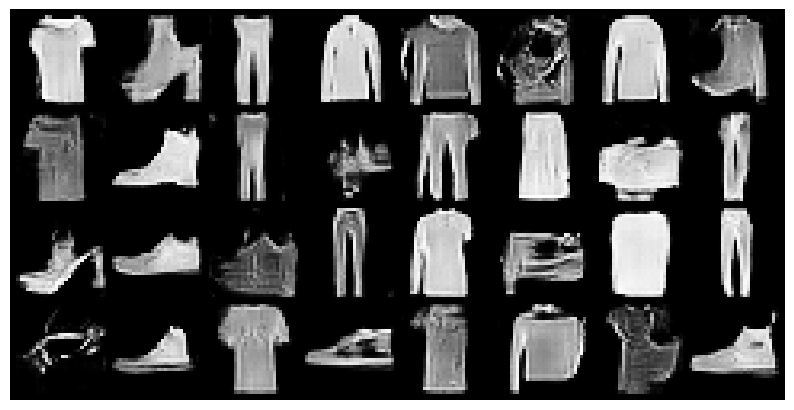

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 2e-4  # slightly lower for DCGAN stability
BATCH_SIZE = 64
Z_DIM = 64
EPOCHS = 10

# --- DATA LOADING (Same as before) ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Normalize to [-1, 1]
])
dataset = torchvision.datasets.FashionMNIST(root="dataset/", transform=transform, download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# --- THE UPGRADE: DCGAN ARCHITECTURE ---

class DCGenerator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        # Input: N x z_dim x 1 x 1
        self.gen = nn.Sequential(
            # 1. Project Noise to 7x7 feature map
            # ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)
            nn.ConvTranspose2d(z_dim, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # 2. Upscale 7x7 -> 14x14
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # 3. Upscale 14x14 -> 28x28 (Output)
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh() # Output is [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

class DCDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.disc = nn.Sequential(
            # 1. Input 28x28 -> 14x14
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True), # LeakyReLU is crucial for Discriminators

            # 2. 14x14 -> 7x7
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # 3. 7x7 -> 1 (Real/Fake Probability)
            nn.Conv2d(128, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.disc(x).view(-1, 1).squeeze(1)

# --- INITIALIZATION ---
gen = DCGenerator(Z_DIM).to(device)
disc = DCDiscriminator().to(device)

# Initialize weights (Good practice for DCGANs)
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

gen.apply(initialize_weights)
disc.apply(initialize_weights)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

# --- TRAINING LOOP (Updated for 4D Tensors) ---
print("Starting DCGAN Training...")

for epoch in range(EPOCHS):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device) # No flattening! Shape: [64, 1, 28, 28]
        batch_size = real.shape[0]

        ### Train Discriminator
        noise = torch.randn(batch_size, Z_DIM, 1, 1).to(device) # Noise is now 4D [N, 64, 1, 1]
        fake = gen(noise)

        disc_real = disc(real)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))

        disc_fake = disc(fake.detach())
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        ### Train Generator
        output = disc(fake)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

    print(f"Epoch [{epoch}/{EPOCHS}] Loss D: {lossD:.4f}, Loss G: {lossG:.4f}")

# --- VISUALIZATION ---
print("Generating sharp images...")
noise = torch.randn(32, Z_DIM, 1, 1).to(device)
fake_images = gen(noise)
grid = torchvision.utils.make_grid(fake_images, nrow=8, normalize=True)
plt.figure(figsize=(10,10))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()